In [1]:
from deep_single_agent_env import DeepSingleAgentEnv
from othello_env import OthelloEnv
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
def dqn(env: DeepSingleAgentEnv, max_iter_count: int = 10000,
                                 gamma: float = 0.99,
                                 alpha: float = 0.1,
                                 epsilon: float = 0.2):
    q = tf.keras.models.Sequential()
    q.add(tf.keras.layers.Input((env.state_dim(),)))
    q.add(tf.keras.layers.Dense(env.max_action_count(),
                                activation=tf.keras.activations.linear,
                                use_bias=True
                                ))

    ema_score = 0.0
    ema_nb_steps = 0.0
    first_episode = True

    step = 0
    ema_score_progress = []
    ema_nb_steps_progress = []

    opt = tf.keras.optimizers.SGD(alpha)

    for _ in tqdm(range(max_iter_count)):
        if env.is_game_over():
            if first_episode:
                ema_score = env.score()
                ema_nb_steps = step
                first_episode = False
            else:
                ema_score = (1 - 0.9) * env.score() + 0.9 * ema_score
                ema_nb_steps = (1 - 0.9) * step + 0.9 * ema_nb_steps
                ema_score_progress.append(ema_score)
                ema_nb_steps_progress.append(ema_nb_steps)

            env.reset()
            step = 0

        s = env.state_description()
        aa = env.available_actions_ids()
        

        q_pred = q(np.array([s]))[0]
        if np.random.random() < epsilon:
            a = np.random.choice(aa)
        else:
            a = aa[np.argmax(q_pred.numpy()[aa])]

        old_score = env.score()
        env.act_with_action_id(a)
        new_score = env.score()
        r = new_score - old_score

        s_p = env.state_description()
        aa_p = env.available_actions_ids()

        if env.is_game_over():
            y = r
        else:
            q_pred_p = q(np.array([s_p]))[0]
            max_q_s_p = np.max(q_pred_p.numpy()[aa_p])
            y = r + gamma * max_q_s_p

        with tf.GradientTape() as tape:
            q_s_a = q(np.array([s]))[0][a]
            loss = tf.reduce_mean((y - q_s_a) ** 2)

        grads = tape.gradient(loss, q.trainable_variables)
        opt.apply_gradients(zip(grads, q.trainable_variables))

        step += 1
    return q, ema_score_progress, ema_nb_steps_progress

In [17]:
q, scores, steps = dqn(OthelloEnv(), epsilon=0.2, max_iter_count=500)
print(q.weights)


100%|██████████| 500/500 [00:06<00:00, 82.61it/s]

[<tf.Variable 'dense_12/kernel:0' shape=(192, 64) dtype=float32, numpy=
array([[ 3.4514701e+13, -9.8486432e+07, -2.0093911e+11, ...,
         3.1734620e+07, -2.3297558e+07, -3.1573664e+10],
       [ 8.7811336e-02, -5.3179331e+05, -8.0078501e+03, ...,
         4.5499891e-02,  4.9274155e+01,  7.1947019e+05],
       [ 1.8143952e-03,  8.7283142e+08, -8.8571744e+07, ...,
        -3.0754208e+08,  6.2586702e+12, -6.8084429e+08],
       ...,
       [-2.0898746e+12, -9.8418096e+07,  6.6755469e+08, ...,
         3.1685602e+07, -2.2981340e+07, -3.2253788e+10],
       [ 7.5349674e-02, -5.7030068e+03,  3.1827807e-02, ...,
        -1.3933682e-01, -3.0270856e+07, -2.8851546e-02],
       [ 3.6604576e+13,  8.7223699e+08, -2.0169525e+11, ...,
        -3.0749309e+08,  6.2587001e+12, -1.4439550e-01]], dtype=float32)>, <tf.Variable 'dense_12/bias:0' shape=(64,) dtype=float32, numpy=
array([ 3.45147011e+13,  7.73813184e+08, -2.01027699e+11,  1.55589417e+17,
        1.96324465e+13, -6.70684979e+09, -4.042772

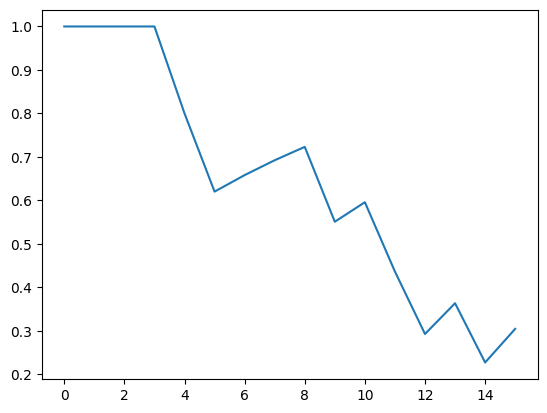

In [18]:
plt.plot(scores)
plt.show()

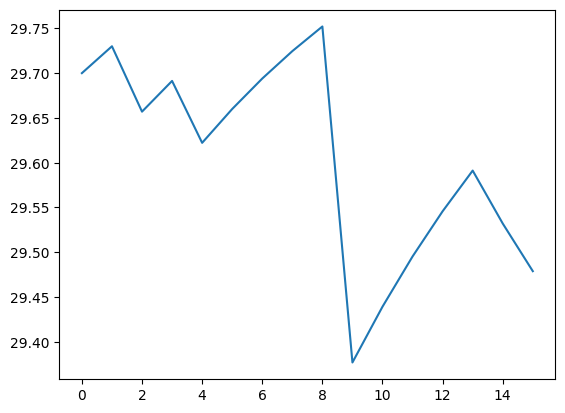

In [19]:
plt.plot(steps)
plt.show()

In [117]:
# Custom DQN

from collections import deque
import random


class DQNAgent():
    def __init__(
        self,
        env:DeepSingleAgentEnv,
        gamma: float = 0.99,
        alpha: float = 0.1,
        
    ):
        self.min_replay_memory_size = 1_000
        self.max_replay_memory_size = 5_000
        self.replay_memory = deque(maxlen=self.max_replay_memory_size)
        self.target_update_counter = 0
        self.update_target_every = 20
        self.gamma = gamma
        self.minibacth_size = 512
        self.alpha = alpha
        self.env = env
        self.model = self.create_model()
        self.target_model = self.create_model()
    
    def create_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Input((self.env.state_dim(),)))
        model.add(tf.keras.layers.Dense(self.env.max_action_count(),
                                    activation=tf.keras.activations.linear,
                                    use_bias=True
                                    ))
        model.compile(
            loss= 'mse',
            optimizer= tf.keras.optimizers.SGD(learning_rate=self.alpha),
            run_eagerly=True
        )
        return model

    def update_replay_memory(self,transition):
        self.replay_memory.append(transition)

    def train(self,terminal_state,steps):
        if len(self.replay_memory)< self.min_replay_memory_size:
            return
        minibatch = random.sample(self.replay_memory,self.minibacth_size)
        curr_states = np.array([transition[0] for transition in minibatch])
        curr_qs_list = self.model.predict(curr_states.reshape(-1,self.env.state_dim()))


        new_curr_states = np.array([transition[3] for transition in minibatch])
        future_qs = self.target_model.predict(new_curr_states.reshape(-1,self.env.state_dim()))

        X = []
        y = []

        for i, (curr_state,action,reward,new_curr_state,done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs[i])
                new_q = reward +self.gamma *max_future_q
            else:
                new_q = reward

            curr_qs = curr_qs_list[i]
            curr_qs[action] = new_q

            X.append(curr_state)
            y.append(curr_qs)

        self.model.fit(np.array(X).reshape(-1,self.env.state_dim()),
                       np.array(y).reshape(-1,self.env.max_action_count()), 
                       batch_size=self.minibacth_size,verbose=0)

        if terminal_state:
            self.target_update_counter+=1

        if self.target_update_counter > self.update_target_every:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
        
    def get_qs(self,state):
        return self.model.predict(state)
        


In [ ]:
def save_model_and_weights(agent:DQNAgent, model_name:str,episode:str, max_reward, average_reward,min_reward):
    checkpoint_name = f"{model_name}_Eps({episode})_max({max_reward})_avg({average_reward}).model"
    agent.model.save(f'models/{checkpoint_name}')
    best_weights = agent.model.get_weights()

    return best_weights

In [133]:
episodes: int = 10_000
epsilon: float = 0.2
save_model_every = 1_000


def dqn(episodes = episodes,epsilon=epsilon):

    env = OthelloEnv()
    agent = DQNAgent(env=env)
    ema_score_progress = []
    ema_nb_steps_progress = []
    first_episode = True

    for i in tqdm(range(1,episodes+1)):

        if env.is_game_over():
            if first_episode:
                ema_score = env.score()
                ema_nb_steps = step
                first_episode = False
            else:
                ema_score = (1 - 0.9) * env.score() + 0.9 * ema_score
                ema_nb_steps = (1 - 0.9) * step + 0.9 * ema_nb_steps
                ema_score_progress.append(ema_score)
                ema_nb_steps_progress.append(ema_nb_steps)

        env.reset()
        curr_state = env.state_description()
        episode_reward = 0
        step = 1

        while not env.is_game_over():

            if np.random.random() > epsilon and not first_episode:
                # Get action from Q table
                weigths_action_sorted = np.argsort(agent.get_qs(curr_state.reshape(-1,env.state_dim())))[0]
                for i in range(len(weigths_action_sorted)-1,-1,-1):
                    if weigths_action_sorted[i] in env.available_actions_ids():
                        action = weigths_action_sorted[i]
                        break

            else:
                # Get random action 
                action = random.choice(env.available_actions_ids())

            old_score = env.score()
            env.act_with_action_id(action)
            new_score = env.score()
            reward = new_score - old_score
            done = env.is_game_over()

            episode_reward += reward
            
            agent.update_replay_memory((curr_state,action,reward,env.state_description(),done))
            agent.train(done,step)
            curr_state = env.state_description()

            step += 1

    return agent.model, ema_score_progress, ema_nb_steps_progress

            

In [143]:
agent = DQNAgent(env=OthelloEnv())
states = agent.env.state_description()
# action= np.argmax(agent.get_qs(states.reshape(-1,192)))

agent.model.save("../models/Othello/dqn_test.h5")


In [132]:
a = [0,8,3,9,10]
for i in range(len(a)-1,-1,-1):
    print(a[i])

10
9
3
8
0


In [119]:
q_model, score, steps = dqn()

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  0%|          | 1/10000 [03:57<660:27:39, 237.79s/it]


KeyboardInterrupt: 